# Read evaluation and generate tables and bar plots
Goal: reproduce result summaries from the platform to integrate them in the paper.

Note: some submissions did not provide predictions for both datasets, so we could either have 8 tables, or we could have 4 tables with a “left” part for Rumsey and a “right” part for IGN, (blank when an entry skipped one of the evaluations).
Which ranking to use is a bit ambiguous here.

Note: We do not change submission names, to ensure consistency with the online platform.
However, we shorten long submission names with ellipses, like for instance “MapText…Strong Pipeline”.
We apply the same function everywhere to make sure this is consistent across the various tasks.

In [1]:
from icdar_maptext_analysis.loaders import list_valid_submission_ids, VALID_TASKS, VALID_SUBSETS, load_valid_evaluations
from icdar_maptext_analysis.submissions_metadata import lookup_generate_title, shorten_title

In [2]:
import os
from IPython.display import display
import matplotlib.pyplot as plt


# original column names to report naming
# These are also the columns to keep in the results
columns_rename_map = {
    # GENERAL INDICATOR
    "hmean": "HMean",

    # TRANSCRIPTION INDICATORS
    # "char_quality": "Char. Quality",
    "char_accuracy": "Char. Acc.",

    # EDGE INDICATORS
    "edges_recall": "Edges Recall",
    "edges_precision": "Edges Precision",
    "edges_fscore": "Edges FScore",

    # DETECTION INDICATORS
    # "quality": "Det. Quality", 
    "tightness": "Tightness", 
    # "fscore": " Det. FScore", 
    "precision": "Det. Precision", 
    "recall": "Det. Recall",
}

columns_to_keep_per_task = {
    1: ["recall", "precision", "tightness", "hmean"],
    2: ["recall", "precision", "tightness", "edges_recall", "edges_precision", "hmean"],
    3: ["recall", "precision", "tightness", "char_accuracy", "hmean"],
    4: ["recall", "precision", "tightness", "char_accuracy", "edges_recall", "edges_precision", "hmean"],
}

subset_rename_map = {
    "rumsey": "Rumsey",
    "ign": "French Land Register",
    "twh": "Chinese Historical Topographic Maps",
}

task_extra_description_for_table = {
    1: "isolated word detection",
    2: "grouped word detection",
    3: "word detection with perfect transcription",
    4: "joint grouped word detection and transcription",
}


def generate_all_tables_and_plot(output_dir: str):
    # get the list of valid submission ids
    valid_submission_ids = list_valid_submission_ids()
    # create output directory
    os.makedirs(output_dir, exist_ok=True)
    for task_id in VALID_TASKS:
        for subset in VALID_SUBSETS:
            # skip tasks 2 and 4 for subset twh
            if subset == "twh" and task_id in [2, 4]:
                continue
            subset_name = subset_rename_map[subset]
            print()
            print(f"Task {task_id}, \"{subset_name}\" subset")
            print("="*80)
            # read the results
            results_global, _results_per_image = load_valid_evaluations(task_id, subset)
            if len(results_global) == 0:
                print(f"No results for task {task_id} on {subset_name} subset")
                continue

            # keep only the columns we are interested in
            keep_columns = columns_to_keep_per_task[task_id]
            results_global = results_global[keep_columns]

            # add method names
            results_global["Method name"] = results_global.index.map(lambda idx: lookup_generate_title(int(idx[2])))
            # shorten the titles
            results_global["Method name"] = results_global["Method name"].str.replace(r'[', "(").str.replace(r']', ')').map(shorten_title)
            # .str.replace(r"[(Baseline)?.?ICDAR'24]", "*").str.replace(r"Baseline", "**")

            # renames columns, sort them and scale their values
            # build the actual renaming map based on the columns present in the results
            columns_rename_map_actual = {k: v for k, v in columns_rename_map.items() if k in results_global.columns}
            results_global.rename(columns=columns_rename_map_actual, inplace=True)
            # get the list of actual columns
            actual_columns = list(columns_rename_map_actual.values())

            # report numbers as 0-100 (percentages) by multiplying by 100
            results_global[actual_columns] *= 100
            # display the results using html rendering
            all_columns = ["Method name"] + actual_columns

            # The sort key is the first columns which actually belongs to columns_rename_map (which is ordered by importance)
            sort_column = [col for col in columns_rename_map.values() if col in actual_columns][0]
            # Add a rank column
            results_global["Rank"] = results_global[sort_column].rank(ascending=False).astype(int)
            all_columns = ["Rank"] + all_columns

            # Display and save the results
            display(results_global[all_columns].sort_values(sort_column, ascending=False))
            # print the results as latex table, using 1 decimal place
            # latex_str = results_global[["Method name", "Quality (%)"]].sort_values(sort_column, ascending=False).to_latex(index=False, float_format="%.1f")
            latex_str = results_global[all_columns].sort_values(sort_column, ascending=False).to_latex(
                index=False,
                float_format="%.1f",
                column_format="cr" + "c" * (len(all_columns) - 2),
                caption=f"Results for task {task_id} ({task_extra_description_for_table[task_id]}) on {subset_name} subset. Values expressed in percentage. For all metrics, higher is better.",
                label=f"tab:task_{task_id}_subset_{subset}",
                position="!tb",
                escape=True,
                )
            # hugly hack to add a resizebox to the table
            latex_str = latex_str.replace(r"\begin{tabular}", r"\resizebox{\textwidth}{!}{\begin{tabular}").replace(r"\end{tabular}", r"\end{tabular}}")
            # print(latex_str)
            # export to file
            with open(os.path.join(output_dir, f"task_{task_id}_subset_{subset}.tex"), "w") as f:
                f.write(latex_str)

            # Increase text size
            plt.rcParams.update({'font.size': 14})
            # plot the results
            results_global[["Method name", sort_column]].sort_values(sort_column, ascending=False).plot.barh(
                x="Method name", y=sort_column, 
                # title=f"Score for task {task_id} on {subset_name} subset", 
                ylabel="", xlabel=sort_column, legend=False, 
                xlim=(0, 100))
            # flip y axis
            plt.gca().invert_yaxis()
            # Adjust layout to ensure labels are not cropped
            plt.tight_layout()
            # export to file
            plt.savefig(os.path.join(output_dir, f"task_{task_id}_subset_{subset}.pdf"), bbox_inches="tight")


Task 1, "Rumsey" subset


Rank                     Method name      HMean  \
task_id subset submission_id                                                    
1       rumsey 124983            1         MapText Strong Pipeline  90.203695   
               124940            2                  Self-Sequencer  88.875619   
               121832            3  (MapText'24 ...Strong Pipeline  88.698606   
               125646            4        Baseline TESTR Finetuned  88.457737   
               125479            5                      PolyTextTR  86.724261   
               124853            6                  MapTextSpotter  84.881351   
               125456            7             CREPE + BezierCurve  81.919934   
               125458            8            YOLOv8-ViTAE-Polygon  60.361168   
               125481            9  Word-Level T...g and PaddleOCR  54.225156   

                              Tightness  Det. Precision  Det. Recall  
task_id subset submission_id                                          
1       rumsey 124983         83.751618       95.884297    91.837848  
               124940         86.137988       91.518529    89.134420  
               121832         82.747932       94.190382    89.922287  
               125646         86.284971       89.135593    90.040332  
               125479         82.482398       90.277101    87.784048  
               124853         81.448965       92.609526    81.514206  
               125456         73.624769       87.096716    86.525787  
               125458         74.371886       54.095641    56.277443  
               125481         73.892059       59.538449    40.006797


Task 1, "French Land Register" subset


Rank               Method name      HMean  \
task_id subset submission_id                                              
1       ign    125646            1  Baseline TESTR Finetuned  76.566297   
               125479            2                PolyTextTR  73.474047   
               125458            3      YOLOv8-ViTAE-Polygon  67.503358   

                              Tightness  Det. Precision  Det. Recall  
task_id subset submission_id                                          
1       ign    125646         69.809324       80.738385    80.184015  
               125479         70.267735       76.523285    73.901401  
               125458         68.466975       63.452929    71.038176


Task 1, "Chinese Historical Topographic Maps" subset


Rank               Method name      HMean  \
task_id subset submission_id                                              
1       twh    124983            1   MapText Strong Pipeline  91.085100   
               125646            2  Baseline TESTR Finetuned  79.359416   
               125479            3                PolyTextTR  72.720135   
               125458            4      YOLOv8-ViTAE-Polygon  33.763082   

                              Tightness  Det. Precision  Det. Recall  
task_id subset submission_id                                          
1       twh    124983         87.456672       96.527012    89.748847  
               125646         88.207058       70.990991    80.779088  
               125479         82.356402       65.467208    72.270630  
               125458         84.931865       15.383334    82.816504


Task 2, "Rumsey" subset


Rank                     Method name      HMean  \
task_id subset submission_id                                                    
2       rumsey 124938            1                  Self-Sequencer  78.422449   
               125455            2             CREPE + BezierCurve  78.394493   
               125647            3  Baseline TES...+ Heuristic MST  55.345737   
               121864            4     (Baseline MapText'24) DS-LP  42.092114   

                              Edges Recall  Edges Precision  Tightness  \
task_id subset submission_id                                             
2       rumsey 124938            61.642090        72.571398  86.137988   
               125455            71.677590        75.714526  73.624769   
               125647            51.080921        27.137106  86.284971   
               121864            16.630257        55.279879  71.629019   

                              Det. Precision  Det. Recall  
task_id subset submission_id                               
2       rumsey 124938              91.518529    89.134420  
               125455              87.096716    86.525787  
               125647              89.135593    90.040332  
               121864              71.756203    78.932401


Task 2, "French Land Register" subset


,,,Rank,Method name,HMean,Edges Recall,Edges Precision,Tightness,Det. Precision,Det. Recall
task_id,subset,submission_id,,,,,,,,
2,ign,125647,1,Baseline TES...+ Heuristic MST,12.503122,28.223844,3.074205,69.809324,80.738385,80.184015



Task 3, "Rumsey" subset


Rank                     Method name      HMean  \
task_id subset submission_id                                                    
3       rumsey 124985            1         MapText Strong Pipeline  91.133506   
               124939            2                  Self-Sequencer  90.299897   
               125648            3        Baseline TESTR Finetuned  89.531083   
               121874            4  (Baseline Ma...Strong Pipeline  89.259039   
               121875            5  (Baseline MapText '24) MapTest  87.370390   
               125454            6             CREPE + BezierCurve  84.934280   
               121876            7  (Baseline Ma... MapTextSpotter  84.520090   
               121877            8     (Baseline MapText'24) DS-LP  77.554718   
               121878            9  (Baseline Ma...ESTR Checkpoint  74.607017   
               125480           10  Word-Level T...g and PaddleOCR  59.461233   
               125463           11    YOLOv8_ViTAE_PolygonDetector  27.422109   

                              Char. Acc.  Tightness  Det. Precision  \
task_id subset submission_id                                          
3       rumsey 124985          94.044699  83.749179       95.884297   
               124939          94.862047  86.136683       91.518529   
               125648          92.915440  86.283135       89.135593   
               121874          93.974266  83.265968       96.162912   
               121875          89.505565  81.816676       90.470689   
               125454          95.473764  73.624596       87.096716   
               121876          83.461540  81.442284       92.609526   
               121877          90.827356  71.625832       71.756203   
               121878          82.103738  79.549984       71.854050   
               125480          83.711115  73.892059       59.538449   
               125463          77.964569  75.966185       61.745005   

                              Det. Recall  
task_id subset submission_id               
3       rumsey 124985           91.837848  
               124939           89.134420  
               125648           90.040332  
               121874           85.009077  
               121875           88.231191  
               125454           86.525787  
               121876           81.514206  
               121877           78.932401  
               121878           66.904249  
               125480           40.006797  
               125463            9.644879


Task 3, "French Land Register" subset


Rank                   Method name      HMean  \
task_id subset submission_id                                                  
3       ign    125648            1      Baseline TESTR Finetuned  79.321580   
               125463            2  YOLOv8_ViTAE_PolygonDetector  20.478097   

                              Char. Acc.  Tightness  Det. Precision  \
task_id subset submission_id                                          
3       ign    125648          88.923050  69.808200       80.738385   
               125463          58.176163  66.796917       65.951743   

                              Det. Recall  
task_id subset submission_id               
3       ign    125648           80.184015  
               125463            6.756386


Task 3, "Chinese Historical Topographic Maps" subset


Rank                   Method name      HMean  \
task_id subset submission_id                                                  
3       twh    124985            1       MapText Strong Pipeline  83.263723   
               125648            2      Baseline TESTR Finetuned  78.380144   
               125463            3  YOLOv8_ViTAE_PolygonDetector  54.564021   

                              Char. Acc.  Tightness  Det. Precision  \
task_id subset submission_id                                          
3       twh    124985          66.211670  87.450407       96.527012   
               125648          75.588772  88.198051       70.990991   
               125463          66.230509  85.274823       35.908428   

                              Det. Recall  
task_id subset submission_id               
3       twh    124985           89.748847  
               125648           80.779088  
               125463           53.664787


Task 4, "Rumsey" subset


Rank                     Method name      HMean  \
task_id subset submission_id                                                    
4       rumsey 125336            1             CREPE + BezierCurve  80.802677   
               124937            2                  Self-Sequencer  80.761951   
               125651            3  Baseline TES...+ Heuristic MST  59.344883   
               121883            4     (Baseline MapText'24) DS-LP  46.225811   

                              Char. Acc.  Edges Recall  Edges Precision  \
task_id subset submission_id                                              
4       rumsey 125336          95.473764     71.675314        75.712122   
               124937          94.862047     61.655744        72.587473   
               125651          92.915440     51.080921        27.137106   
               121883          90.827356     16.630257        55.279879   

                              Tightness  Det. Precision  Det. Recall  
task_id subset submission_id                                          
4       rumsey 125336         73.624596       87.096716    86.525787  
               124937         86.136683       91.518529    89.134420  
               125651         86.283135       89.135593    90.040332  
               121883         71.625832       71.756203    78.932401


Task 4, "French Land Register" subset


,,,Rank,Method name,HMean,Char. Acc.,Edges Recall,Edges Precision,Tightness,Det. Precision,Det. Recall
task_id,subset,submission_id,,,,,,,,,
4,ign,125651,1,Baseline TES...+ Heuristic MST,14.593355,88.92305,28.223844,3.074205,69.8082,80.738385,80.184015


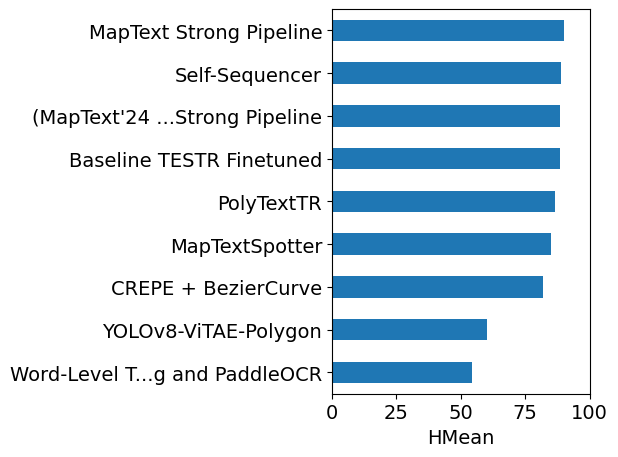

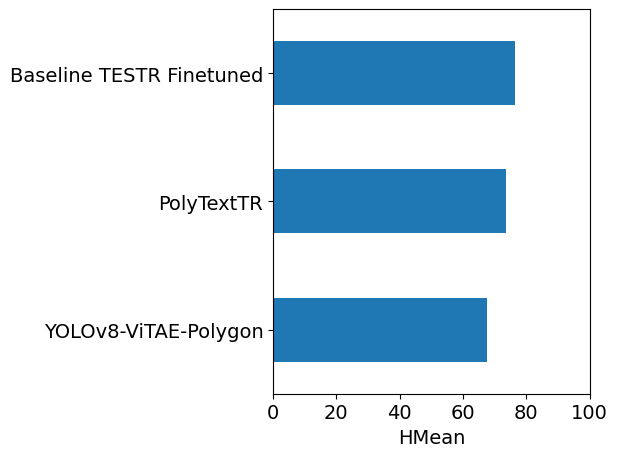

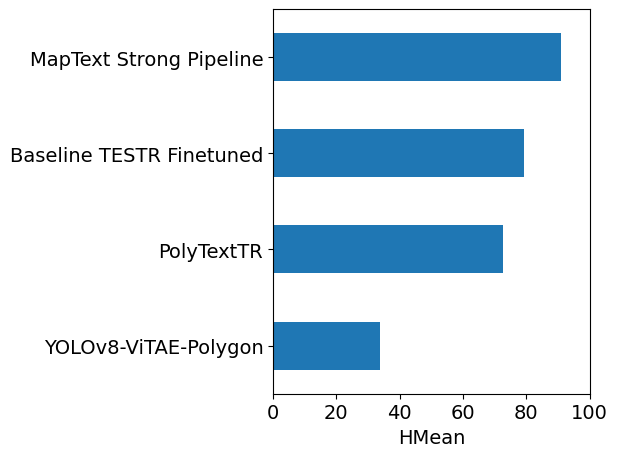

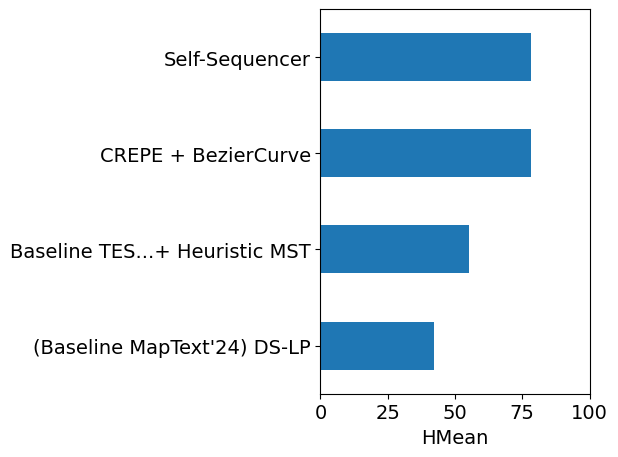

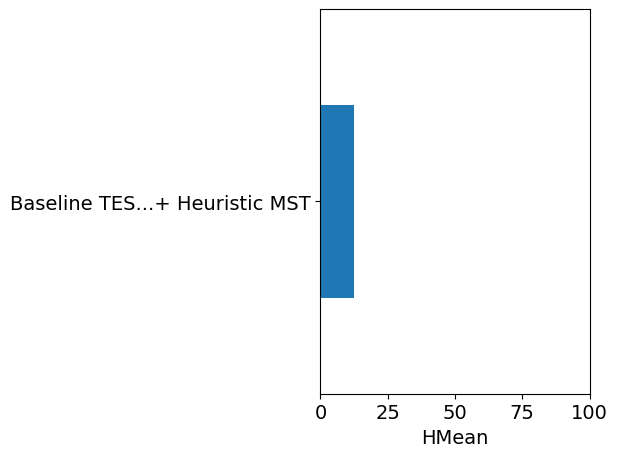

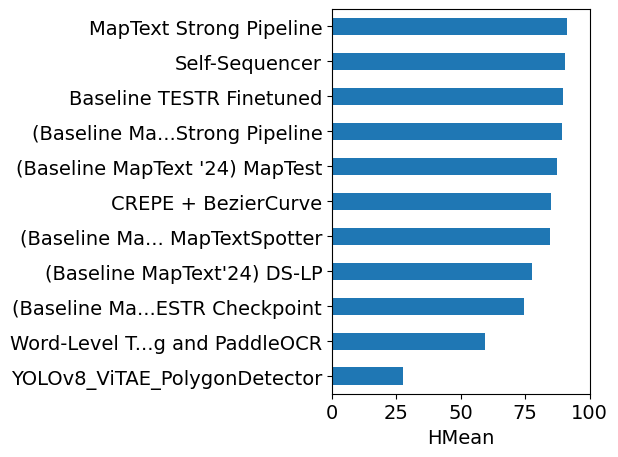

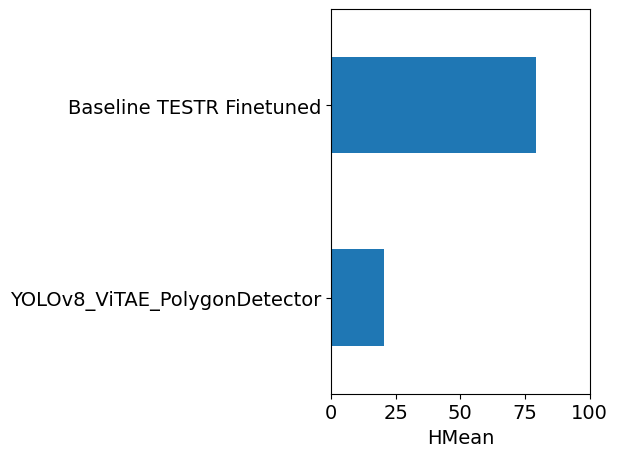

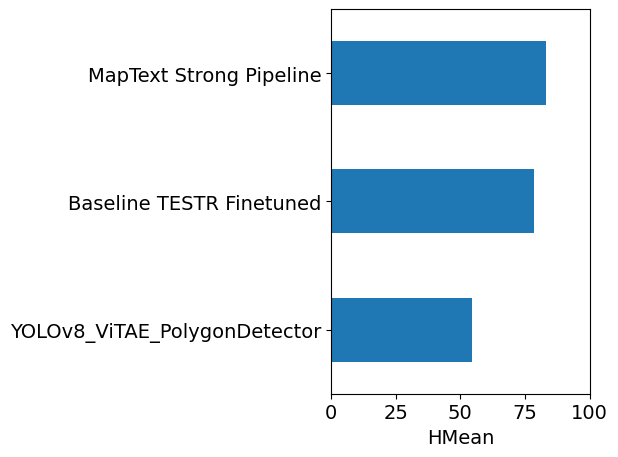

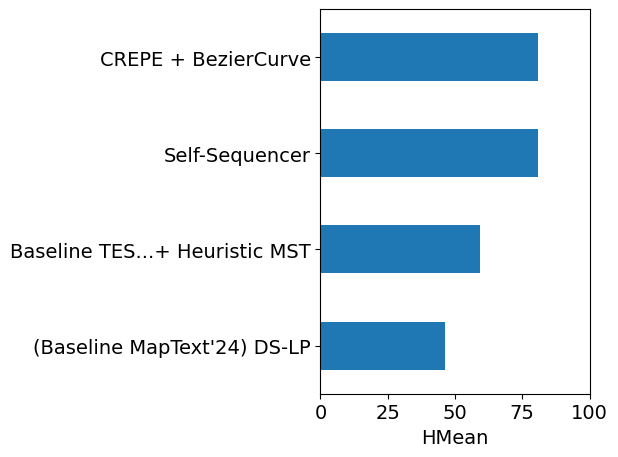

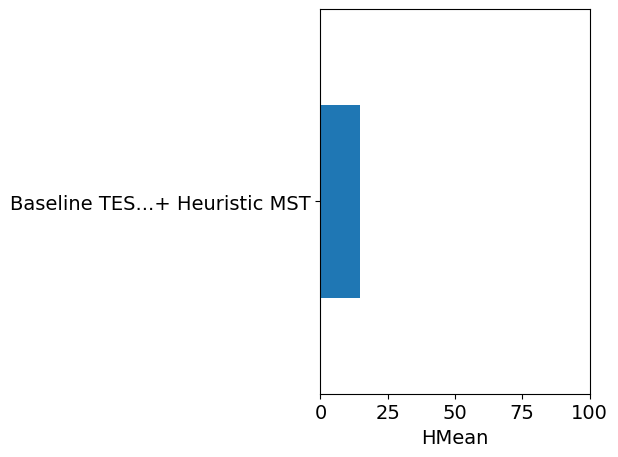

In [3]:
generate_all_tables_and_plot("data/10-tables-and-plots/")